In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from torchxlstm import sLSTM, mLSTM, xLSTM 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import scipy.io

# 
# 
emg_features_mat_path = 'D:\\ly\\sEMG\\SIAT-DNS\\emg_features_examples.mat'
emg_features_data = scipy.io.loadmat(emg_features_mat_path)

In [3]:
sEMG_data = emg_features_data['examples']
angles = emg_features_data['angle_labels']
torques = emg_features_data['torque_labels']

sEMG_values = sEMG_data.astype('float32')
sEMG_scaler = MinMaxScaler(feature_range=(0, 1))
sEMG_normalized = np.zeros_like(sEMG_data)
for i in range(9):
    scaler = MinMaxScaler(feature_range=(0, 1))
    sEMG_normalized[:, i, :] = scaler.fit_transform(sEMG_data[:, i, :])

joint_angles_values = angles.astype('float32')
angles_scaler = MinMaxScaler(feature_range=(0, 1))
angles_normalized = angles_scaler.fit_transform(joint_angles_values)

joint_torques_values = torques.astype('float32')
torques_scaler = MinMaxScaler(feature_range=(0, 1))
torques_normalized = torques_scaler.fit_transform(joint_torques_values)

len(sEMG_normalized), len(angles_normalized), len(torques_normalized)


(22551, 22551, 22551)

In [4]:
'''
train_size = int(len(sEMG_normalized) * 0.2 * 0.8)
test_size = int((len(sEMG_normalized)*0.2) - train_size)
'''
train_size = int(len(sEMG_normalized) * 0.8)
test_size = len(sEMG_normalized) - train_size

train_sEMG = sEMG_normalized[:train_size]
test_sEMG = sEMG_normalized[train_size:(test_size+train_size)]

train_angles = angles_normalized[:train_size]
test_angles = angles_normalized[train_size:(test_size+train_size)]

train_torques = torques_normalized[:train_size]
test_torques = torques_normalized[train_size:(test_size+train_size)]

len(train_sEMG), len(test_sEMG), len(train_angles), len(test_angles), len(train_torques), len(test_torques)

(18040, 4511, 18040, 4511, 18040, 4511)

In [ ]:
def create_dataset(sEMG_data, angles_data, seq_len):
    dataX, dataY = [], []
    for i in range(len(sEMG_data) - seq_len + 1):
        a = sEMG_data[i:(i + seq_len)]
        dataX.append(a)
        dataY.append(angles_data[i + seq_len - 1])
    return torch.tensor(dataX, dtype=torch.float32), torch.tensor(dataY, dtype=torch.float32)


# DNS torques24.10.24

seq_len = 1926  # SIAT论文P4  a total of nine-channel sEMG signals were collected by using a wireless acquisition system sampled at 1926 Hz
trainX, trainY = create_dataset(train_sEMG, train_torques, seq_len)  
testX, testY = create_dataset(test_sEMG, test_torques, seq_len)

print("Training data shape:", trainX.shape, trainY.shape)
print("Testing data shape:", testX.shape, testY.shape)


# X_train, X_test, y_angles_train, y_angles_test, y_torques_train, y_torques_test
# Create data loaders
train_dataset = TensorDataset(trainX, trainY)
test_dataset = TensorDataset(testX, testY)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class EMGModel(nn.Module):
    def __init__(self, input_channels, input_features, hidden_size, num_heads, model_type):
        super(EMGModel, self).__init__()
        self.input_projection = nn.Linear(input_channels * input_features, hidden_size)
        
        if model_type == 'xLSTM':
            self.rnn = xLSTM(hidden_size, hidden_size, num_heads, batch_first=True, layers='msm')
        elif model_type == 'LSTM':
            self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        elif model_type == 'sLSTM':
            self.rnn = sLSTM(hidden_size, hidden_size, num_heads, batch_first=True)
        elif model_type == 'mLSTM':
            self.rnn = mLSTM(hidden_size, hidden_size, num_heads, batch_first=True)
        
        self.output = nn.Linear(hidden_size, 8) 
    
    def forward(self, x):
        batch_size, seq_len, input_channels, input_features = x.size()
        x = x.view(batch_size, seq_len, -1)
        x = self.input_projection(x)
        
        if isinstance(self.rnn, nn.LSTM):
            x, _ = self.rnn(x)
        else:
            x, _ = self.rnn(x)
        
        x = self.output(x[:, -1, :])
        return x
    
# 定义模型
input_channels = 9
input_features = 6
hidden_size = 32
num_heads = 2

models = {
    "LSTM": EMGModel(input_channels, input_features, hidden_size, num_heads, 'LSTM'),
    # "sLSTM": EMGModel(input_channels, input_features, hidden_size, num_heads, 'sLSTM'),
    # "mLSTM": EMGModel(input_channels, input_features, hidden_size, num_heads, 'mLSTM'),
    # "xLSTM": EMGModel(input_channels, input_features, hidden_size, num_heads, 'xLSTM'),
}

Using device: cuda


Training LSTM:   5%|▌         | 1/20 [00:03<01:13,  3.86s/it]

0.12923663363579646


Training LSTM:  10%|█         | 2/20 [00:07<01:06,  3.69s/it]

0.08915626100577999


Training LSTM:  15%|█▌        | 3/20 [00:11<01:02,  3.67s/it]

0.08153462835273384


Training LSTM:  20%|██        | 4/20 [00:14<00:58,  3.67s/it]

0.07521939717631006


Training LSTM:  25%|██▌       | 5/20 [00:18<00:54,  3.65s/it]

0.07100303800882952


Training LSTM:  30%|███       | 6/20 [00:21<00:50,  3.63s/it]

0.0674356262811724


Training LSTM:  35%|███▌      | 7/20 [00:25<00:47,  3.65s/it]

0.06382921485988226


Training LSTM:  40%|████      | 8/20 [00:29<00:43,  3.66s/it]

0.06130185551392349


Training LSTM:  45%|████▌     | 9/20 [00:32<00:39,  3.63s/it]

0.059308653551227594


Training LSTM:  50%|█████     | 10/20 [00:36<00:36,  3.62s/it]

0.06411140835930551


Training LSTM:  55%|█████▌    | 11/20 [00:40<00:32,  3.63s/it]

0.05707842054453934


Training LSTM:  60%|██████    | 12/20 [00:43<00:29,  3.65s/it]

0.05556936210982646


Training LSTM:  65%|██████▌   | 13/20 [00:47<00:25,  3.63s/it]

0.054413171946886434


Training LSTM:  70%|███████   | 14/20 [00:51<00:21,  3.65s/it]

0.053851307033302105


Training LSTM:  75%|███████▌  | 15/20 [00:54<00:18,  3.66s/it]

0.0520399836831383


Training LSTM:  80%|████████  | 16/20 [00:58<00:14,  3.67s/it]

0.05068525076904363


Training LSTM:  85%|████████▌ | 17/20 [01:02<00:10,  3.64s/it]

0.04937781650699301


Training LSTM:  90%|█████████ | 18/20 [01:05<00:07,  3.64s/it]

0.049432057513957094


Training LSTM:  95%|█████████▌| 19/20 [01:09<00:03,  3.64s/it]

0.048617142699935854


Training LSTM: 100%|██████████| 20/20 [01:12<00:00,  3.65s/it]

0.047869750300974366


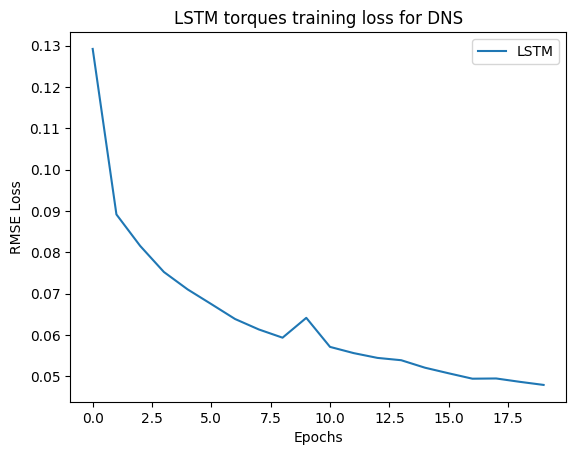

Returning from train_model: model type: <class '__main__.EMGModel'>, train_losses type: <class 'list'>


Training sLSTM:   5%|▌         | 1/20 [39:14<12:25:43, 2354.90s/it]

0.14717308361341958


Training sLSTM:  10%|█         | 2/20 [1:18:45<11:49:11, 2363.95s/it]

0.10391265409942856


Training sLSTM:  15%|█▌        | 3/20 [1:57:53<11:07:44, 2356.76s/it]

0.10311476236578274


Training sLSTM:  20%|██        | 4/20 [2:38:03<10:34:04, 2377.79s/it]

0.0973385054063462


Training sLSTM:  25%|██▌       | 5/20 [3:18:59<10:01:28, 2405.91s/it]

0.08944299280617826


Training sLSTM:  30%|███       | 6/20 [3:58:57<9:20:48, 2403.48s/it] 

0.08801346359403019


Training sLSTM:  35%|███▌      | 7/20 [4:39:45<8:43:53, 2417.94s/it]

0.08306918877071483


Training sLSTM:  40%|████      | 8/20 [5:20:34<8:05:33, 2427.82s/it]

0.08401050346884859


Training sLSTM:  45%|████▌     | 9/20 [6:00:43<7:23:59, 2421.76s/it]

0.12709553212814959


Training sLSTM:  50%|█████     | 10/20 [6:40:23<6:41:31, 2409.13s/it]

0.10396901828030532


Training sLSTM:  55%|█████▌    | 11/20 [7:19:37<5:58:48, 2392.04s/it]

0.1022612001886427


Training sLSTM:  60%|██████    | 12/20 [7:58:30<5:16:34, 2374.28s/it]

0.0994869907053611


Training sLSTM:  65%|██████▌   | 13/20 [8:37:58<4:36:45, 2372.15s/it]

0.10191334984943934


Training sLSTM:  70%|███████   | 14/20 [9:16:34<3:55:31, 2355.22s/it]

0.09947909304464952


Training sLSTM:  75%|███████▌  | 15/20 [9:55:18<3:15:28, 2345.78s/it]

0.09792880606569672


Training sLSTM:  80%|████████  | 16/20 [10:34:39<2:36:42, 2350.53s/it]

0.09433991135545881


Training sLSTM:  85%|████████▌ | 17/20 [11:14:06<1:57:46, 2355.38s/it]

0.09238224881184005


Training sLSTM:  90%|█████████ | 18/20 [11:52:54<1:18:14, 2347.22s/it]

0.09175746888833256


Training sLSTM:  95%|█████████▌| 19/20 [12:32:18<39:12, 2352.27s/it]  

0.09058053940058591


Training sLSTM: 100%|██████████| 20/20 [13:10:11<00:00, 2370.58s/it]

0.10863866605088376


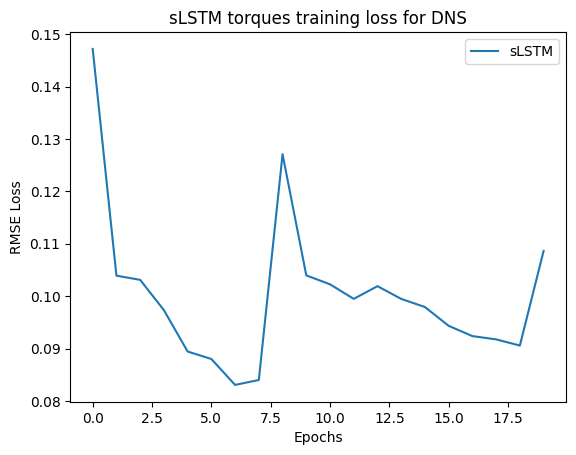

Returning from train_model: model type: <class '__main__.EMGModel'>, train_losses type: <class 'list'>


Training mLSTM:   5%|▌         | 1/20 [32:21<10:14:54, 1941.80s/it]

0.13026369598163187


Training mLSTM:  10%|█         | 2/20 [1:05:38<9:52:14, 1974.12s/it]

0.09982986874710903


Training mLSTM:  15%|█▌        | 3/20 [1:38:08<9:16:15, 1963.28s/it]

0.0921002766051101


Training mLSTM:  20%|██        | 4/20 [2:10:04<8:38:28, 1944.29s/it]

0.08628998411700307


Training mLSTM:  25%|██▌       | 5/20 [2:42:38<8:06:56, 1947.79s/it]

0.08473704183292687


Training mLSTM:  30%|███       | 6/20 [3:15:51<7:38:04, 1963.19s/it]

0.08276236539071091


Training mLSTM:  35%|███▌      | 7/20 [3:47:50<7:02:13, 1948.71s/it]

0.07843342760719381


Training mLSTM:  40%|████      | 8/20 [4:19:34<6:26:57, 1934.77s/it]

0.07779512262088968


Training mLSTM:  45%|████▌     | 9/20 [4:52:22<5:56:36, 1945.11s/it]

0.07717413805456512


Training mLSTM:  50%|█████     | 10/20 [5:25:06<5:25:09, 1950.91s/it]

0.0743196723971401


Training mLSTM:  55%|█████▌    | 11/20 [5:57:05<4:51:08, 1940.97s/it]

0.076743117483618


Training mLSTM:  60%|██████    | 12/20 [6:29:28<4:18:52, 1941.59s/it]

0.07293048695055683


Training mLSTM:  65%|██████▌   | 13/20 [7:02:42<3:48:22, 1957.57s/it]

0.07206621116042933


Training mLSTM:  70%|███████   | 14/20 [7:35:18<3:15:43, 1957.18s/it]

0.0711900251061233


Training mLSTM:  75%|███████▌  | 15/20 [8:06:57<2:41:37, 1939.48s/it]

0.07150109966430675


Training mLSTM:  80%|████████  | 16/20 [8:39:30<2:09:35, 1943.75s/it]

0.07988578795161742


Training mLSTM:  85%|████████▌ | 17/20 [9:12:33<1:37:46, 1955.38s/it]

0.07889813712146426


Training mLSTM:  90%|█████████ | 18/20 [9:44:37<1:04:51, 1945.92s/it]

0.07412301325024304


Training mLSTM:  95%|█████████▌| 19/20 [10:17:43<32:38, 1958.14s/it] 

0.06950649195516359


Training mLSTM: 100%|██████████| 20/20 [10:50:38<00:00, 1951.94s/it]

0.06818713793118295


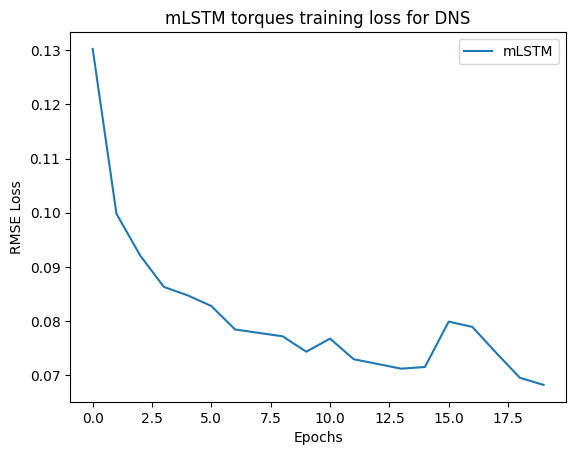

Returning from train_model: model type: <class '__main__.EMGModel'>, train_losses type: <class 'list'>


Training xLSTM:   5%|▌         | 1/20 [1:41:22<32:06:08, 6082.57s/it]

0.15353084606751355


Training xLSTM:  10%|█         | 2/20 [3:23:22<30:31:26, 6104.80s/it]

0.1069591768896176


Training xLSTM:  15%|█▌        | 3/20 [5:06:28<29:00:10, 6141.81s/it]

0.09790387480756675


Training xLSTM:  20%|██        | 4/20 [6:49:41<27:23:09, 6161.84s/it]

0.09178606037741062


Training xLSTM:  25%|██▌       | 5/20 [8:32:50<25:42:57, 6171.85s/it]

0.08703914018170343


Training xLSTM:  30%|███       | 6/20 [10:14:58<23:56:34, 6156.74s/it]

0.08542256446682961


Training xLSTM:  35%|███▌      | 7/20 [11:57:32<22:13:45, 6155.78s/it]

0.08144851599369039


Training xLSTM:  40%|████      | 8/20 [13:39:59<20:30:36, 6153.06s/it]

0.08586136499084414


Training xLSTM:  45%|████▌     | 9/20 [15:22:33<18:48:05, 6153.24s/it]

0.0820080460719988


Training xLSTM:  50%|█████     | 10/20 [17:05:51<17:07:51, 6167.13s/it]

0.0790599084784193


Training xLSTM:  55%|█████▌    | 11/20 [18:48:20<15:24:15, 6161.68s/it]

0.07339090108519887


Training xLSTM:  60%|██████    | 12/20 [20:31:38<13:43:02, 6172.76s/it]

0.07401740078340127


Training xLSTM:  65%|██████▌   | 13/20 [22:13:20<11:57:38, 6151.16s/it]

0.07071853155123868


Training xLSTM:  70%|███████   | 14/20 [23:57:37<10:18:19, 6183.28s/it]

0.07370849352893201


Training xLSTM:  75%|███████▌  | 15/20 [25:42:55<8:38:39, 6223.80s/it] 

0.06826495017241742


Training xLSTM:  80%|████████  | 16/20 [27:20:15<6:47:13, 6108.46s/it]

0.0677369746760582


Training xLSTM:  85%|████████▌ | 17/20 [28:51:41<4:56:03, 5921.03s/it]

0.06565332414811417


Training xLSTM:  90%|█████████ | 18/20 [30:22:55<3:12:53, 5786.70s/it]

0.07200891949218666


Training xLSTM:  95%|█████████▌| 19/20 [31:53:47<1:34:46, 5686.30s/it]

0.0638942401504103


Training xLSTM: 100%|██████████| 20/20 [33:24:44<00:00, 6014.20s/it]  

0.06319000396001616


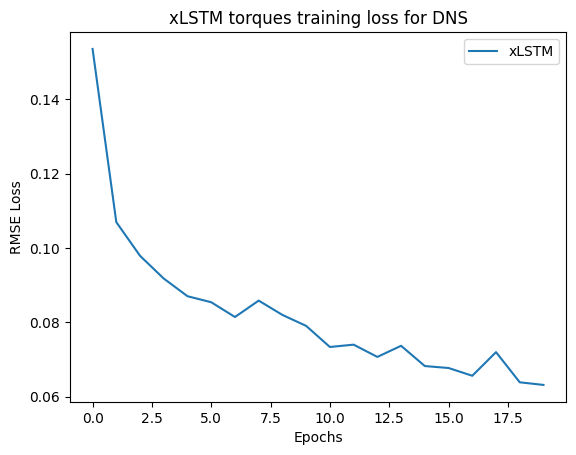

Returning from train_model: model type: <class '__main__.EMGModel'>, train_losses type: <class 'list'>


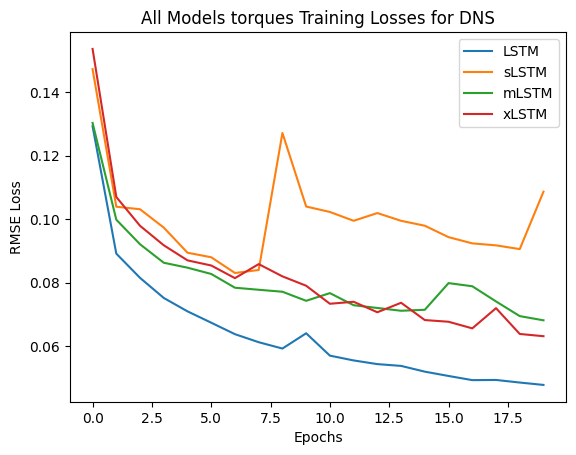

In [ ]:
import math
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
# Training process
def train_model(model, model_name, epochs, learning_rate, flag1, flag2):
    model = model.to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    for epoch in tqdm(range(epochs), desc=f'Training {model_name}'):
        model.train()
        epoch_loss = 0
        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        torch.cuda.synchronize()
        lossp = math.sqrt(epoch_loss / len(train_loader))
        print(lossp)
        train_losses.append(lossp)
        torch.cuda.empty_cache()

    plt.plot(train_losses, label=model_name)
    plt.title(f'{model_name} {flag1} training loss for {flag2}')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE Loss')
    plt.legend()
    plt.show()

    print(f"Returning from train_model: model type: {type(model)}, train_losses type: {type(train_losses)}")
    return model, train_losses

# Train the models
trained_models = {}
all_train_losses = {}
flag1 = 'torques'
flag2 = 'DNS'
for model_name, model in models.items():
    trained_models[model_name], all_train_losses[model_name] = train_model(model, model_name, epochs=20, learning_rate=0.01, flag1=flag1, flag2=flag2)

# Plot losses for each model
plt.figure()
for model_name, train_losses in all_train_losses.items():
    plt.plot(train_losses, label=model_name)

# Plot all model losses compared
plt.title(f'All Models {flag1} Training Losses for {flag2}')
plt.xlabel('Epochs')
plt.ylabel('RMSE Loss')
plt.legend()
plt.show()

# Evaluate models on test data
def evaluate_model(model, data_loader):
    model = model.to(device)
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy())
    return predictions

test_predictions = {}
for model_name, model in trained_models.items():
    test_predictions[model_name] = evaluate_model(model, test_loader)

# Plot predictions for each model
for model_name, preds in test_predictions.items():
    # Inverse transform the predictions and actual values
    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
    actual = scaler.inverse_transform(testY.numpy().reshape(-1, 1))

    plt.figure()
    plt.plot(actual, label='Actual')
    plt.plot(preds, label=model_name + ' Predictions')
    plt.title(f'{model_name} are predicted for {flag2} {flag1} with actual results')
    plt.legend()
    plt.show()


# Plot all model predictions compared
plt.figure()
plt.plot(actual, label='Actual')
for model_name, preds in test_predictions.items():
    # Inverse transform the predictions 
    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
    plt.plot(preds, label=model_name + ' Predictions')

plt.title(f'All models are predicted for {flag2} {flag1} with actual results')
plt.legend()
plt.show()

In [ ]:
sLSTM = [0.14717308361341958, 0.10391265409942856, 0.0973385054063462, 0.08801346359403019, 0.08306918877071483, 0.08401050346884859, 0.12709553212814959, 0.10396901828030532, 0.1022612001886427, 0.0994869907053611, 0.10191334984943934]
